# Project: Neural Machine Translation

In this project, we construct a neural machine translation system using an encoder-decoder architecture with attention mechanism and beam search decoding.

In [ ]:
import json
import math
import random
import pdb
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import sacrebleu
import sentencepiece
import tqdm.notebook
import matplotlib.pyplot as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data

We use the Multi30K dataset with German and English.



In [ ]:
extensions = [".de", ".en"]
source_field = torchtext.data.Field(tokenize=lambda x: x)
target_field = torchtext.data.Field(tokenize=lambda x: x)
training_data, validation_data, test_data = torchtext.datasets.Multi30k.splits(
    extensions, [source_field, target_field], root=".")

## Vocabulary

We use `sentencepiece` to create a German-English vocabulary from the training corpus. The small vocabulary size is for efficiency in training (small model).

In [ ]:
args = {
    "pad_id": 0,
    "bos_id": 1,
    "eos_id": 2,
    "unk_id": 3,
    "input": "multi30k/train.de,multi30k/train.en",
    "vocab_size": 8000,
    "model_prefix": "multi30k",
}
combined_args = " ".join(
    "--{}={}".format(key, value) for key, value in args.items())
sentencepiece.SentencePieceTrainer.Train(combined_args)

This creates two files: `multi30k.model` and `multi30k.vocab`. The first is a binary file containing the relevant data for the vocabulary. The second is a human-readable listing of each subword and its associated score.

Loading the vocabulary:

In [ ]:
vocab = sentencepiece.SentencePieceProcessor()
vocab.Load("multi30k.model")

In [ ]:
pad_id = vocab.PieceToId("<pad>")
bos_id = vocab.PieceToId("<s>")
eos_id = vocab.PieceToId("</s>")

## Baseline seq2seq model

We first implement the basic seq2seq encoder-decoder model without attention.

We begin by implementing a data batcher.

In [ ]:
def make_batch(sentences):
  """Convert a list of sentences into a batch of subword indices.
  Args:
    sentences: A list of sentences, each of which is a string.

  Returns:
    LongTensor with dimension (max_sequence_length, batch_size) containing 
    subword indices for the input sentences. Short sentences are padded.
  """
  sentence_ids = [torch.tensor([bos_id]+vocab.EncodeAsIds(sentence)+[eos_id]) for sentence in sentences]
  sentence_tensor = nn.utils.rnn.pad_sequence(sentence_ids, padding_value=pad_id)

  return sentence_tensor.long()

def make_batch_iterator(dataset, batch_size, shuffle=False):
  """Make a batch iterator that yields source-target pairs.

  Args:
    dataset: torchtext dataset
    batch_size: int
    shuffle: boolean to shuffle samples

  Yields:
    Pairs of tensors containing the outputs of make_batch
  """
  examples = list(dataset)
  if shuffle:
    random.shuffle(examples)

  for start_index in range(0, len(examples), batch_size):
    example_batch = examples[start_index:start_index + batch_size]
    source_sentences = [example.src for example in example_batch]
    target_sentences = [example.trg for example in example_batch]
    yield make_batch(source_sentences), make_batch(target_sentences)

Now we build the base model: encoder with a 2-layer bidirectional LSTM with hidden dimension 256 and dropout with $p=0.5$. The decoder is a 2-layer LSTM with hidden dimension 256.

In [ ]:
class Seq2seqBaseline(nn.Module):
  def __init__(self):
    super().__init__()
    self.vocab_size = 8000
    self.hidden_size = 256
    self.num_layers = 2

    self.embed = nn.Embedding(self.vocab_size,self.hidden_size)
    self.encoder = nn.LSTM(self.hidden_size, self.hidden_size, self.num_layers, dropout=0.5, bidirectional=True)
    self.decoder = nn.LSTM(self.hidden_size, self.hidden_size, self.num_layers, dropout=0.5)
    self.out = nn.Linear(self.hidden_size, self.vocab_size)

  def encode(self, source):
    """Encode source using a bidirectional LSTM.

    Args:
      source: An integer tensor with shape (max_source_sequence_length,
        batch_size) containing subword indices for source sentences.

    Returns:
      A tuple with three elements:
        encoder_output: The output of the bidirectional LSTM with shape
          (max_source_sequence_length, batch_size, 2 * hidden_size).
        encoder_mask: A boolean tensor with shape (max_source_sequence_length,
          batch_size) with True if that index is a pad token
        encoder_hidden: The final hidden states of the bidirectional LSTM to be 
          input into the decoder. A pair of tensors (h_n, c_n), each with shape
          (num_layers, batch_size, hidden_size). 
    """

    lengths = torch.sum(source != pad_id, axis=0).cpu()
    embed = self.embed(source)
    encoded, (ht, ct) = self.encoder(embed)
    # combining bidirectional outputs by addition
    ht = ht[:self.num_layers] + ht[self.num_layers:]
    ct = ct[:self.num_layers] + ct[self.num_layers:]

    encoder_mask = (source == pad_id)
    
    return (encoded, encoder_mask, (ht, ct))

  def decode(self, decoder_input, initial_hidden, encoder_output, encoder_mask):
    """Decode inputs using encoder hidden states.

    Args:
      decoder_input: An integer tensor with shape (max_decoder_sequence_length,
        batch_size) containing the subword indices for the decoder input.
      initial_hidden: A pair of tensors representing the initial
        state of the decoder, each with shape (num_layers, batch_size,
        hidden_size).
      encoder_output: None for baseline
      encoder_mask: None for baseline

    Returns:
      A tuple with three elements:
        logits: A tensor with shape (max_decoder_sequence_length, batch_size,
          vocab_size) with logits for next-word predictions.
        decoder_hidden: A pair of tensors (h_n, c_n) with the same shape as
          initial_hidden representing the updated decoder state after processing
          the decoder input.
        attention_weights: None for baseline
    """
    del encoder_output
    del encoder_mask

    decoder_input = self.embed(decoder_input)
    decoded, state = self.decoder(decoder_input, initial_hidden)
    output = self.out(decoded)

    return (output, state, None)

  def compute_loss(self, source, target):
    """Compute the loss on the target for a model output.

    Args:
      source: An integer tensor with shape (max_source_sequence_length,
        batch_size) containing subword indices for the source sentences.
      target: An integer tensor with shape (max_target_sequence_length,
        batch_size) containing subword indices for the target sentences.

    Returns:
      A float tensor representing cross-entropy loss on the current batch.
    """
    enc_output, enc_mask, enc_hidden = self.encode(source)
    # ignore the last token of the target (EOS token) since it doesn't give a viable output
    dec_input = target[:-1]
    dec_output, dec_hidden, att_weights = self.decode(dec_input, enc_hidden, enc_output, enc_mask)
    loss = F.cross_entropy(dec_output.permute(1,2,0), target[1:].permute(1,0), ignore_index=pad_id)

    return loss

We use a helper training function.

In [ ]:
def train(model, num_epochs, batch_size, model_file):
  """Train the model and save the checkpoint with the best validation loss."""
  optimizer = torch.optim.Adam(model.parameters())
  best_accuracy = 0.0
  for epoch in tqdm.notebook.trange(num_epochs, desc="training", unit="epoch"):
    with tqdm.notebook.tqdm(
        make_batch_iterator(training_data, batch_size, shuffle=True),
        desc="epoch {}".format(epoch + 1),
        unit="batch",
        total=math.ceil(len(training_data) / batch_size)) as batch_iterator:
      model.train()
      total_loss = 0.0
      for i, (source, target) in enumerate(batch_iterator, start=1):
        source, target = source.to(device), target.to(device)
        optimizer.zero_grad()
        loss = model.compute_loss(source, target)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        batch_iterator.set_postfix(mean_loss=total_loss / i)
      validation_perplexity, validation_accuracy = evaluate_next_token(
          model, validation_data)
      batch_iterator.set_postfix(
          mean_loss=total_loss / i,
          validation_perplexity=validation_perplexity,
          validation_token_accuracy=validation_accuracy)
      if validation_accuracy > best_accuracy:
        print(
            f"New best validation accuracy of {validation_accuracy}, saving model "
            f"checkpoint to {model_file}")
        torch.save(model.state_dict(), model_file)
        best_accuracy = validation_accuracy
  print(f"Reloading best model checkpoint from {model_file}")
  model.load_state_dict(torch.load(model_file))

def evaluate_next_token(model, dataset, batch_size=64):
  """Compute token-level perplexity and accuracy metrics."""
  model.eval()
  total_cross_entropy = 0.0
  total_predictions = 0
  correct_predictions = 0
  with torch.no_grad():
    for source, target in make_batch_iterator(dataset, batch_size):
      source, target = source.to(device), target.to(device)
      encoder_output, encoder_mask, encoder_hidden = model.encode(source)
      decoder_input, decoder_target = target[:-1], target[1:]
      logits, decoder_hidden, attention_weights = model.decode(
          decoder_input, encoder_hidden, encoder_output, encoder_mask)
      total_cross_entropy += F.cross_entropy(
          logits.permute(1, 2, 0), decoder_target.permute(1, 0),
          ignore_index=pad_id, reduction="sum").item()
      total_predictions += (decoder_target != pad_id).sum().item()
      correct_predictions += (
          (decoder_target != pad_id) &
          (decoder_target == logits.argmax(2))).sum().item()
  perplexity = math.exp(total_cross_entropy / total_predictions)
  accuracy = 100 * correct_predictions / total_predictions
  return perplexity, accuracy

Training the base seq2seq model.

In [ ]:
num_epochs = 10
batch_size = 16

baseline_model = Seq2seqBaseline().to(device)
train(baseline_model, num_epochs, batch_size, "baseline_model.pt")

Implementing greedy decoding (we compare to beam search decoding later).

In [ ]:
def predict_greedy(model, sentences, max_length=100):
  """Return predictions for the given inputs using greedy inference.
  
  Args:
    model: A sequence-to-sequence model.
    sentences: A list of strings of input sentences.
    max_length: Maximum allowed length of outputs before manually termination.
  
  Returns:
    A list of strings of predicted translations.
  """
  batch = make_batch(sentences)
  outputs = []
  batch = batch.to(device)

  model.eval()

  with torch.no_grad():
    encoder_output, encoder_mask, encoder_hidden = model.encode(batch)
    sentence_ids = torch.LongTensor([bos_id]*batch.shape[1]).unsqueeze(0).to(device)
    sentence_length = 0
    decoder_input = sentence_ids
    decoder_hidden = encoder_hidden
    eos_pad_idxs = torch.zeros(batch.shape[1]).to(device)
    
    while not torch.all(eos_pad_idxs == 1) and (sentence_length < max_length):
      sentence_length += 1

      logits, decoder_state, attention_weights = model.decode(
        decoder_input, decoder_hidden, encoder_output, encoder_mask)

      # force pad_id output if the example at idx in the batch has output an eos token
      logits[-1,:,pad_id] += 1e9*eos_pad_idxs

      # add new ids to the sentence_ids tensor
      word_ids = torch.argmax(logits[-1], dim=-1)
      sentence_ids = torch.cat((sentence_ids, word_ids.unsqueeze(0)), axis=0)

      # initialize for next loop
      decoder_hidden = decoder_state
      decoder_input = sentence_ids[-1].unsqueeze(0)
      eos_pad_idxs = ((eos_pad_idxs == 1) | (word_ids == eos_id) | (word_ids == pad_id))


  model.train()

  for sentence in sentence_ids.T:
    output = vocab.DecodeIds(sentence.tolist())
    outputs.append(output)

  return outputs

A helper evaluation function, set up to allow for comparison to a later-implemented beam search.

In [ ]:
def evaluate(model, dataset, batch_size=64, method="greedy", k=5):
  assert method in {"greedy", "beam"}
  source_sentences = [example.src for example in dataset]
  target_sentences = [example.trg for example in dataset]
  model.eval()
  predictions = []
  with torch.no_grad():
    for start_index in range(0, len(source_sentences), batch_size):
      if method == "greedy":
        prediction_batch = predict_greedy(
            model, source_sentences[start_index:start_index + batch_size])
      else:
        prediction_batch = predict_beam(
            model, source_sentences[start_index:start_index + batch_size], k=k)
        prediction_batch = [candidates[0] for candidates in prediction_batch]
      predictions.extend(prediction_batch)
  return sacrebleu.corpus_bleu(predictions, [target_sentences]).score

In [ ]:
print("Baseline model validation BLEU using greedy search:",
      evaluate(baseline_model, validation_data))

A simple function that shows the example outputs.

In [ ]:
def show_predictions(model, num_examples=4, include_beam=False, k=5):
  for example in validation_data[:num_examples]:
    print("Input:")
    print(" ", example.src)
    print("Target:")
    print(" ", example.trg)
    print("Greedy prediction:")
    print(" ", predict_greedy(model, [example.src])[0])
    if include_beam:
      print("Beam predictions:")
      for candidate in predict_beam(model, [example.src], k=k)[0]:
        print(" ", candidate)

In [ ]:
print("Baseline model sample predictions:")
show_predictions(baseline_model)

## Including attention

We implement basic bilinear, dot-product attention, where the attention distribution over the encoder outputs $e_1, \dots, e_n$ (with directions summed to give the correct dimensions) given a decoder LSTM output $d$ is obtained via softmax: $w_i \propto \exp ( d^\top e_i )$.

Attention is included in decoding by a weighted sum of the projected encoder outputs to obtain the attention context $c = \sum_i w_i e_i$, and added to the decoder output $d$ to obtain the final representation to be passed to the vocabulary projection layer.

In [ ]:
class Seq2seqAttention(Seq2seqBaseline):
  def __init__(self):
    super().__init__()
    self.hidden_size = 256
    self.concat = nn.Linear(2*self.hidden_size, self.hidden_size)

  def decode(self, decoder_input, initial_hidden, encoder_output, encoder_mask):
    """Run the decoder LSTM starting from an initial hidden state.

    Args:
      decoder_input: An integer tensor with shape (max_decoder_sequence_length,
        batch_size) containing the subword indices for the decoder input.
      initial_hidden: A pair of tensors representing the initial
        state of the decoder, each with shape (num_layers, batch_size,
        hidden_size).
      encoder_output: The output of the encoder with shape
        (max_source_sequence_length, batch_size, 2 * hidden_size).
      encoder_mask: The output mask from the encoder with shape
        (max_source_sequence_length, batch_size), with True at pad tokens.

    Returns:
      A tuple with three elements:
        logits: A tensor with shape (max_decoder_sequence_length, batch_size,
          vocab_size) with logits for next-word predictions.
        decoder_hidden: A pair of tensors (h_n, c_n) with the same shape as
          initial_hidden representing the updated decoder state after processing
          the decoder input.
        attention_weights: None for baseline
    """
    # squashing bidirectional encoded output
    encoder_output = encoder_output[:,:,:self.hidden_size] + encoder_output[:,:,self.hidden_size:]

    # getting first decoder output
    decoder_input = self.embed(decoder_input)
    decoded, state = self.decoder(decoder_input, initial_hidden)

    # getting attn scores and weights
    attn_scores = torch.einsum('ijk,ljk->lji', [encoder_output, decoded])
    # masking scores
    attn_scores[:, encoder_mask.T] = -1e9
    attn_weights = F.softmax(attn_scores, dim=-1)

    context = torch.einsum('lji,ijk->ljk', [attn_weights, encoder_output])
    concat_input = torch.cat((decoded, context), dim=-1)
    concat_output = self.concat(concat_input)
    output = self.out(concat_output)

    return (output, state, attn_weights)

Training and evaluation:

In [ ]:
num_epochs = 10
batch_size = 16

attention_model = Seq2seqAttention().to(device)
train(attention_model, num_epochs, batch_size, "attention_model.pt")

In [ ]:
print("Attention model validation BLEU using greedy search:",
      evaluate(attention_model, validation_data))

## Beam Search

We now implement $k$-beam search, keeping the best $k$ candidates at each decoding step.

In [ ]:
def predict_beam(model, sentences, k=5, max_length=100):
  """Decoding outputs with beam search with width k
  Args:
    model: A sequence-to-sequence model.
    sentences: A list of strings of input sentences.
    k: The size of the beam.
    max_length: Maximum allowed length of outputs before manually termination.

  Returns:
    A list of list of strings of beam predictions. Each element in the list is a
    list of k strings corresponding to the top k predictions for the input,
    sorted in descending order by score.
  """
  batch = make_batch(sentences)
  batch = batch.to(device)
  batch_size = batch.shape[1]
  outputs = []
  vocab_size = 8000
  num_layers = 2
  hidden_size = 256

  model.eval()

  with torch.no_grad():
    beam = torch.LongTensor([[bos_id]*k for _ in range(batch_size)]).unsqueeze(0).to(device)
    encoder_output, encoder_mask, encoder_hidden = model.encode(batch)


    ######## FIRST ITERATE #######
    decoder_input = torch.tensor([bos_id]*batch_size).unsqueeze(0).to(device)
    decoder_hidden = encoder_hidden
    logits, decoder_state, _ = model.decode(
    decoder_input, decoder_hidden, encoder_output, encoder_mask)
    scores = F.log_softmax(logits.squeeze(0), dim=-1)
    topk_scores, topk_indices = torch.topk(scores, k, dim=-1)

    # update beam, scores, eos_pad
    beam = torch.cat((beam, topk_indices.unsqueeze(0)), dim=0)
    beam_scores = topk_scores
    eos_pad = torch.logical_or(beam[-1] == eos_id, beam[-1] == pad_id)

    encoder_output = encoder_output.repeat_interleave(k, 1)
    encoder_mask = encoder_mask.repeat_interleave(k, 1)
    last_state = (decoder_state[0].repeat_interleave(k, 1), decoder_state[1].repeat_interleave(k, 1))

    ######## GENERAL ITERATES #######
    while (not torch.all(eos_pad == 1)) and (beam.shape[0] < max_length):
      decoder_input = beam[-1].reshape(1, -1)
      decoder_hidden = last_state
      logits, decoder_state, _ = model.decode(
      decoder_input, decoder_hidden, encoder_output, encoder_mask)
      logits = logits.squeeze(0)
      logits[:,pad_id] += 1e9*eos_pad.flatten()
      scores = F.log_softmax(logits, dim=-1)
      
      # add scores from the sequences in the beam -- broadcasting across the vocab_size
      scores += beam_scores.flatten().unsqueeze(1)
      batch_scores = scores.reshape(batch_size, -1)
      topk_scores, topk_indices = torch.topk(batch_scores, k, dim=-1)

      # get the sequence and index corresponding to each of the topk
      topk_seq_number = torch.floor(topk_indices/vocab_size).long()
      topk_seq_idx = torch.fmod(topk_indices, vocab_size)

      # redefine beam using the new topk sequences
      expanded_topk_seq_number = topk_seq_number.unsqueeze(0).repeat(beam.shape[0], 1, 1)
      prefix_beam = torch.gather(beam, 2, expanded_topk_seq_number) 

      # get new states
      reshaped_h = decoder_state[0].reshape(num_layers, batch_size, k, -1)
      reshaped_c = decoder_state[1].reshape(num_layers, batch_size, k, -1)
      state_topk_seq_number = topk_seq_number.reshape(1, batch_size, k, 1).repeat(num_layers, 1, 1, hidden_size)
      new_state_h = torch.gather(reshaped_h, 2, state_topk_seq_number).reshape(num_layers, -1, hidden_size)
      new_state_c = torch.gather(reshaped_c, 2, state_topk_seq_number).reshape(num_layers, -1, hidden_size)

      new_state = (new_state_h, new_state_c)

      # attach the outputs to the prefix beam, beam_score
      new_beam = torch.cat((prefix_beam, topk_seq_idx.unsqueeze(0)), dim=0)
      new_beam_scores = topk_scores

      # update eos_pad
      # update beam, beam_score, decoder state
      eos_pad = torch.logical_or(topk_seq_idx == eos_id, topk_seq_idx == pad_id)
      beam = new_beam
      beam_scores = new_beam_scores
      last_state = new_state
    
  ###### POST-PROCESS #######
  total_seq_len = beam.shape[0]
  eos_indicator = (beam == eos_id)
  idx_finder = torch.arange(total_seq_len).to(device).reshape(-1, 1, 1)
  seq_lengths = torch.mul(eos_indicator, idx_finder).sum(dim=0)

  # normalize scores by seq_lengths and sort the corresponding beam
  norm_scores = torch.div(beam_scores, seq_lengths)
  sorted_norm_scores, sorted_norm_indices = norm_scores.sort(dim=1, descending=True)
  sorted_beam = torch.gather(beam, 2, sorted_norm_indices.repeat(total_seq_len, 1, 1))

  for i in range(batch_size):
    batch_decoded = [vocab.DecodeIds(sorted_beam[:,i,j].tolist()) for j in range(k)]
    outputs.append(batch_decoded)

  return outputs

In [ ]:
print("Baseline model validation BLEU using beam search:",
      evaluate(baseline_model, validation_data, method="beam", k=5))
print("Baseline model sample predictions:")
show_predictions(baseline_model, include_beam=True, k=5)

## Visualizing attention

We implement a basic visualization of examples of decoder attention on gold source-target pairs from the validation data.

In [ ]:
v_source = [example.src for example in validation_data]
v_target = [example.trg for example in validation_data]

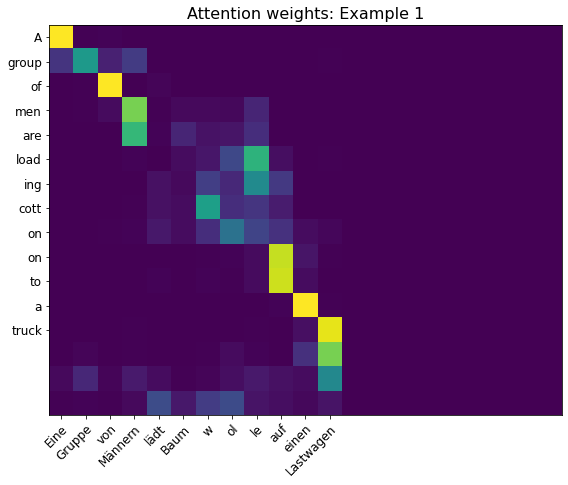

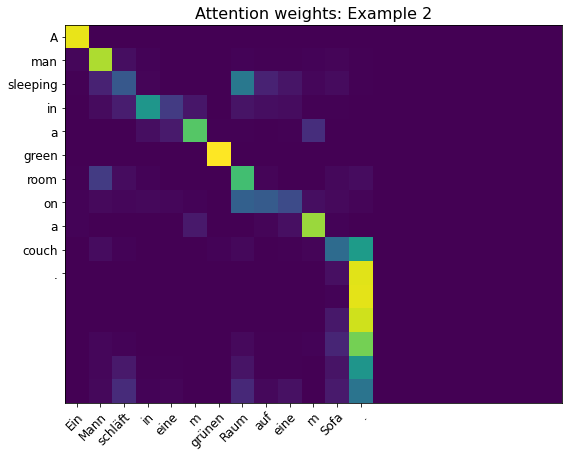

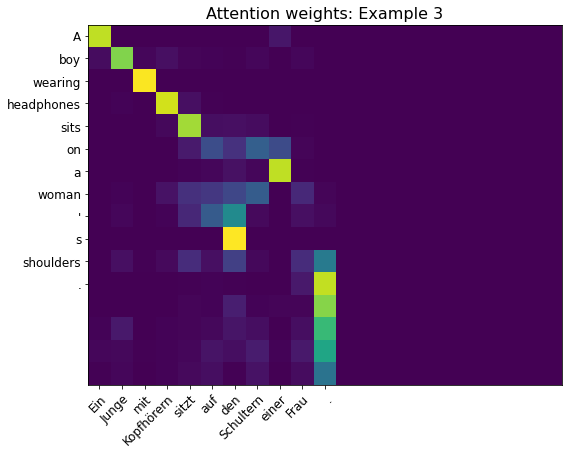

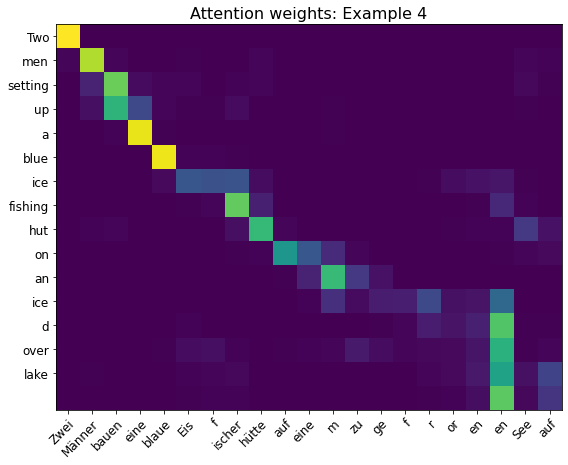

In [ ]:
source_sen = make_batch(v_source[:4]).to(device)
target_sen = make_batch(v_target[:4]).to(device)

encoder_output, encoder_mask, encoder_hidden = attention_model.encode(source_sen)

decoder_input = target_sen
decoder_hidden = encoder_hidden

logits, decoder_state, attention_weights = attention_model.decode(
        decoder_input, decoder_hidden, encoder_output, encoder_mask)

for i in range(4):
  attn = attention_weights[1:,i,2:]
  source_tokens = vocab.EncodeAsPieces(v_source[i])
  target_tokens = vocab.EncodeAsPieces(v_target[i])

  source_tokens = [word[1:] if word[0]=='▁' else word for word in source_tokens]
  target_tokens = [word[1:] if word[0]=='▁' else word for word in target_tokens]

  fig, ax = plt.subplots(figsize=(8,8))
  attn = attn.cpu()
  attn = attn.detach().numpy()

  im = ax.imshow(attn)

  ax.set_xticks(np.arange(len(source_tokens)), labels=source_tokens, fontsize=12)
  ax.set_yticks(np.arange(len(target_tokens)), labels=target_tokens, fontsize=12)

  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
  
  ax.set_title(f"Attention weights: Example {i+1}", fontsize=16)
  fig.tight_layout()
  plt.savefig(f'Example{i+1}.pdf', bbox_inches='tight')
  plt.show()